## Assignment : Graphical Social Network analysis and ML 

Social Network these days are a part of our everyday life which paves the way for using social network analysis as a tool to solving wide variety of issues in the industry. In a recent [article](https://www.nytimes.com/2019/06/02/us/us-visa-application-social-media.html) published by the NY Times, the US immigrant authorities are using the social media information of its applicants in order to grant them a visa status in the country. Millions of applications are processed every year, making it next to impossible to sit through every user's social media profiles and analyse their credibility!

Now, Imagine yourself working for the US authorities. You are approached by your client to find a possible solution to this problem. Your task is to extract information(features) from a sample of dataset to find the most potential or eligible candidates. 

As a first part of this assignment, we will try to find a way to solve this using some critical measures in graphical network analysis. Our dataset [edges.csv] contains a graph with nodes as your applicants, and edges representing their connections. For the second part of the assignment, you will learn basic ML modelling in spark framework and the importance of hyperparameter tuning to choose the best model for your dataset. 

After completing this assignment, you should be able to answer the following questions:

### Graphical Network: Centrality Measures
* What are the measures of centrality? 
* What are the different types of most commonly used centrality measures?
* Why are they important for a graphical networks ? 

### ML Modelling 
* Choosing the right model for your dataset.
* ML Model implementation in spark using pipelines.  

### HyperParameter Tuning
* Why hyperparameter tuning?
* What is cross-validation?
* How to tune parameters?

Notes: 
* Information on the dataset : The data collected from Facebook is in two files : 
      1. `facebook_info.csv` : contains the profile information of facebook users. 
      2. `facebook_edges.csv` : contains networking information of these profiles. Each record is in format "a b" denoting `a` is facebook friend of `b` and vice-versa. Also, the graph can be assumed to be `UNDIRECTED`.
       
* For ease of setup and simplicity, I would recommend using [networkx](https://networkx.github.io/). However, there are few other tools like [graph-tool](https://graph-tool.skewed.de/static/doc/index.html), [gephi](https://gephi.org/), [netwulf](https://github.com/benmaier/netwulf/) etc. Feel free to use any tool of your choice. 

* You can either use Spark DataFrame or pandas.DataFrame to do the assignment. In comparison, pandas.DataFrame has richer APIs, but is not good at distributed computing.

## Part 1: Centrality Measures

In graph theory and network analysis, indicators of centrality identify the most important vertices within a graph. Applications include identifying the most influential person(s) in a social network. These centrality measures in graphical network answers a very basic question : "Who is the most important or central person in the network?". Before proceeding ahead, I would strongly recommend you to read centrality and its different measures [online](https://en.wikipedia.org/wiki/Centrality).

In our scenario, we will try using centrality as a tool for identifying most prominent applicants. 

For the first step, we read the data as DataFrames and further implement algorithms related to centrality measures to understand their importance in graphical analysis. 

In [3]:
import os
import pandas as pd
#<-- Write Your Code -->
source = "data/dataset/"

#Read the edges file as dataframe
df_edges = pd.read_csv(source+"facebook_edges.csv")
df_edges.head(10)

node0  node1
0    881    858
1    828    697
2    884    864
3    856    869
4    889    856
5    872    873
6    719    713
7    861    863
8    840    803
9    864    856

Now, create a labelled graph from about `1000` random samples of the dataframe and save the image as A.png. (For higher number of nodes this steps takes time.) 

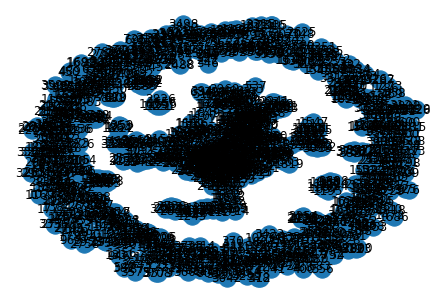

In [26]:
from networkx import *
#from graph_tool.all import *
import matplotlib.pyplot as plt

#<-- Write Your Code -->
g= Graph(directed=False)
df_graph = df_edges.sample(n=1000,replace=False,axis=0)
for i,rows in df_graph.iterrows():
    g.add_edge(rows[0],rows[1])
draw(g, with_labels=True)
plt.savefig("A.png", format="PNG",figsize=(10,10))

### Task 1a: Degree Centrality
For this step we will find `Degree centrality measure`, which is one of the simplest centrality measure to compute. A node's degree is simply a count of how many social connections (i.e., edges) it has. To compute degree centrality you need to divide this value by `N-1`. Write a code to find the degree centrality of each node.  
* **Please note** you are not allowed to use `in-built function for computing degree_centrality` in this step. Try to implement it yourself.  
* Store the values for each node, in a new dataframe with a column `degree_centrality`, index being the vertices.

In [27]:
#<-- Write Your Code -->

def get_degree_centrality(g,node,n):
    ''' Function returns degree centrality measure for each vertex (node)
    Args:
    g (obj): graph object  
    node (int): vertex index 
    n (int)  : total number of nodes in the graph minus 1
    Returns:
    Float value denoting the degree measure of the vertex
    '''
    return (len([p for p in g.neighbors(node)])/n)


nodes = g.nodes()
df = pd.DataFrame(index=nodes)
N= len(nodes)
df['degree_centrality'] = df.index.map(lambda x: get_degree_centrality(g,x,N-1))
df.head()

degree_centrality
2446           0.003019
2055           0.003774
1912           0.004528
2038           0.001509
1668           0.001509

Display the top 10 nodes with highest degree centrality values in a graph. Save this image as B.png.

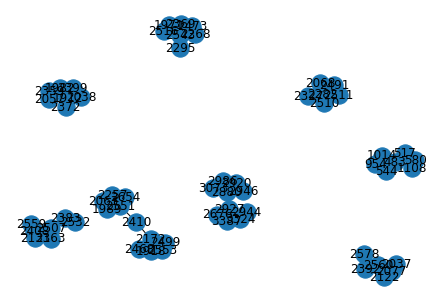

In [30]:
#<-- Write Your Code -->

## Get the top nodes with high centrality 
max_nodes = 10
high_degree_nodes = (df['degree_centrality'].sort_values(ascending=False)[:max_nodes]).index

## Add these nodes to a new graph 
g1= Graph(directed=False)
for i,rows in df_graph.iterrows():
    if(rows[0] in high_degree_nodes or rows[1] in high_degree_nodes):
        g1.add_edge(rows[0],rows[1])
draw(g1, with_labels=True)
plt.savefig("B.png", format="PNG")

Degree centrality represents a measure of how many connections a person has. Higher values mean the user has more connections and therefore, is highly "important" for our analysis. However, imagine a spam user who happens to have many fake friends, has a high degree centrality value. In such scenarios, these numbers could really be misleading. A user's importance should not only depend upon how many connections it has but also how many connections its neighbors have (and how many connections its neighbors' neighbors have and so on). Identifying whether he is a `key` connector in the graph is also important. Going further, we use two more critical measures : Betweenness and Eigenvector centrality. We will notice that each centrality measure indicates a different type of node importance.  

### Task 1b : Betweenness (node) centrality

One another metric is betweenness centrality, which identifies people who frequently are on the shortest paths between pairs of other people. Recall [Assignment 6 from CMPT 732](https://coursys.sfu.ca/2018fa-cmpt-732-g1/pages/Assign6) where we implemented a parallelized version of Dijkstra's Algorithm in Spark. As a part of this segment, we will implement a simple algorithm to find the node centrality, i.e the number of shortest paths that each node is a part of. Centrality of node `i` is computed by adding up, for every other pair of nodes `j` and `k`, the number of shortest paths between node `j` and node `k` that pass through `i`. Please complete the function below that takes in the graph and returns a dictionary with their node centrality values. Note that you are allowed to use in-built functions for getting the shortest path between two nodes. 

In [31]:
#<-- Write Your Code -->

def get_node_centrality(graph):
    """ Funtion returns a dictionary with each vertex as index and 
    no. of shortest paths that the vertex is a part of as its value.
    Args: 
    graph : graph object
    Return:
    n_spaths : (dict) vertex as keys and values as no. shortest paths
    """
    n_spaths = dict.fromkeys(graph,0.0)
    s= dict(all_pairs_shortest_path(graph))
    # write logic for counting the number of shortest paths each node is a part of. 
    for source in graph:
            for path in s[source].values():
                for node in path[1:]: # ignore firs element (source == node)
                    n_spaths[node] += 1 # this path passes through `node`
    return n_spaths

## Add this value to original dataframe. 
node_centrality = get_node_centrality(g)
from sklearn.preprocessing import minmax_scale
df['node_centrality'] = df.index.map(lambda x: node_centrality[x])
df['node_centrality'] = minmax_scale(df['node_centrality'])
df.head()

degree_centrality  node_centrality
2446           0.003019         0.453952
2055           0.003774         0.604572
1912           0.004528         0.441150
2038           0.001509         0.059961
1668           0.001509         0.071979

Betweenness centrality is a **normalized form** of nodal centrality measure. It is computed by adding up, for every other pair of nodes `j` and `k`, the `proportion` of shortest paths between node `j` and node `k` that pass through `i`. I would highly reccommend you to read about this measure [ online ](https://en.wikipedia.org/wiki/Betweenness_centrality). 

In [34]:
### Find betweenness centrality
bet = betweenness_centrality(g, normalized=True)
df['betweenness_centrality'] = df.index.map(lambda x: bet[x])
df.head()

degree_centrality  node_centrality  betweenness_centrality
2446           0.003019         0.453952                0.001703
2055           0.003774         0.604572                0.002668
1912           0.004528         0.441150                0.001838
2038           0.001509         0.059961                0.000174
1668           0.001509         0.071979                0.000251

### Task 1c: EigenVector Centrality

As we saw before, computing shortest paths is kind of a pain. For this reason, node and betweenness centrality isn't often used on large networks. The less intuitive (but generally easier to compute) eigenvector centrality is more frequently used. Eigenvector centralities are numbers, one per user, such that each user’s value is a constant multiple of the sum of his neighbors’ values. In this case centrality means being connected to people who themselves are central. The more centrality you are directly connected to, the more central you are. This is of course a circular definition — eigenvectors are the way of breaking out of the circularity. I highly recommend you to read about eigenvectors and their role in finding the centrality measure. **Please note**, for this task you are allowed to use the in-built function for computing eigenvector centrality but before that, please make sure you understand how it works. 

In [48]:
#<-- Write Your Code -->
# Find EigenVector centrality (the student should choose a high value for max_iter for the algorithm to converge)
eig = eigenvector_centrality(g, max_iter=200)
df['eighenvector_centrality'] = df.index.map(lambda x: eig[x])
df.head()

degree_centrality  node_centrality  betweenness_centrality  \
0            0.001509         0.002743                0.000009   
1            0.000755         0.000000                0.000000   
20           0.000755         0.000000                0.000000   
26           0.001509         0.001960                0.000006   
38           0.000755         0.000000                0.000000   

    eighenvector_centrality  
0              2.498123e-18  
1              7.102622e-41  
20             7.102622e-41  
26             2.196813e-18  
38             7.102622e-41

##### To inspect the difference between various centrality values we plot the top 100 users with highest degree centrality showing how these numbers can be different for different users. To give an idea, your graph should be somewhat like the plot given below.  

**Please Note** : Generally, the centrality numbers aren’t that meaningful themselves. What we really care about is how the numbers for each node compare to the numbers for other nodes. Hence, for the purpose of plot you are allowed to multiply centrality values by a common factor to bring it in a reasonable range. 

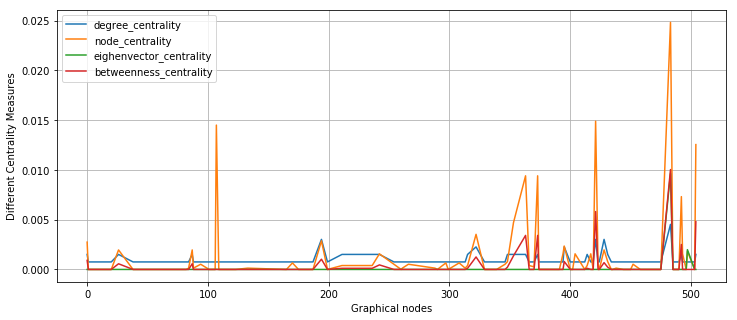

In [58]:
#<-- Write Your Code -->
df = df.sort_index()[:100]
plt.figure(figsize=(12,5))
plt.plot(df.index,df['degree_centrality'],label="degree_centrality")
plt.plot(df.index,df['node_centrality'],label="node_centrality")
plt.plot(df.index,df['eighenvector_centrality']*1000,label="eighenvector_centrality")
plt.plot(df.index,df['betweenness_centrality']*100,label="betweenness_centrality")
plt.legend()
plt.xlabel("Graphical nodes")
plt.ylabel("Different Centrality Measures")
plt.grid()
plt.show()

Observe the graph closely and write two most interesting insights from the above comparison plot.
* [1] For most part of the graph, degree and betweenness centrality change consistently. However, Eithenvector centrality values are somewhat independent of these two parameters. This suggests that even though a user who can have a high degree and betweenness measure can have low eigenvector measure (or vice-versa). Hence, it will be misleading to just consider degree and betweennnes measures to identify importance of a user in the graphical structure. 

* [2] If we observe closely, the node centrality measure, follows the same pattern as betweenness centrality, justifying the relationship that we proved above (Task 1b) that betweenness centrality is nothing but a normalized form of node centrality. 

In this part of the assignment, we focussed on finding the critical users (nodes) by establishing a connection between their centrality measures in graphical networks. Apart from US immigration, you can think of many other scenarios where this method can be useful. For example, say you are in the recruiting team of your company which is looking to hire data scientists. Since there are a lot of applicants, instead of just going through their resumes (since they all look the same anyway! ;) ), you plan on using their coorporate social media profiles (on linkedin) for finding the most "renowned" data scientists for your company. 

## Part 2: Modelling and HyperParameter Tuning in Spark
### Task 2a:  ML Modelling

An important task in ML is model selection, or using data to find the best model or parameters for a given task. This is also called tuning. Tuning may be done for individual Estimators such as LogisticRegression, or for entire Pipelines which include multiple algorithms, featurization, and other steps. Users can tune an entire Pipeline at once, rather than tuning each element in the Pipeline separately.

Now as a part of this step, you have the social media information from a bunch of facebook users (`facebook_info.csv`) and you want to build a classification model to predicate their gender: "male (0)" or "female (1)".

In [59]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('ml_tuning_in_spark').getOrCreate()
sc = spark.sparkContext
#spark_df = spark.read.csv('data/dataset/facebook_info.csv', header=True, inferSchema=True)
spark_df = spark.read.parquet('data/dataset/facebook_info.parquet')

spark_df.printSchema()

# Prepare training and test data.
(training_df, test_df) = spark_df.randomSplit([0.7, 0.3], seed = 100)
#training_df.printSchema()

root
 |-- index: long (nullable = true)
 |-- age: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- tenure: double (nullable = true)
 |-- friend_count: long (nullable = true)
 |-- friendships_initiated: long (nullable = true)
 |-- likes: long (nullable = true)
 |-- likes_received: long (nullable = true)
 |-- mobile_likes: long (nullable = true)
 |-- mobile_likes_received: long (nullable = true)
 |-- www_likes: long (nullable = true)
 |-- www_likes_received: long (nullable = true)
 |-- __index_level_0__: long (nullable = true)



 You are expected to finish the Spark program that can help you to do the job. I highly recommend you to read through the [Spark ML Classification Programming Guide](http://spark.apache.org/docs/latest/ml-classification-regression.html), which is very well written, and will aid your understanding of the code. You can train an ML model (any algorithm that you think is suitable) for the kind of dataset you are provided.

In [60]:
#<-- Write Your Code -->
#Initialize a classification model that you seem fit with suitable parameters (ex. Naive Bayes, Logistic regression etc.)

from pyspark.ml.classification import LogisticRegression
#from pyspark.ml.classification import NaiveBayes

ml_method = LogisticRegression(maxIter=20,regParam=0.3)
#ml_method = NaiveBayes(smoothing=1.0, modelType="multinomial")

Now, lets say we need to do some preprocessing steps before modelling : like [StringIndexer](https://spark.apache.org/docs/latest/ml-features.html#stringindexer) for prediction class and [VectorAssembler](https://spark.apache.org/docs/latest/ml-features.html#vectorassembler) for representing features in vector form. We build an ML [Pipeline](http://spark.apache.org/docs/latest/ml-pipeline.html) and chain the Indexer and Assembler along with your ml model.  Try to understand and complete the code below.

In [61]:
from pyspark.ml.feature import StringIndexer,VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# StringIndexer to convert our label into numerical categories
labelIndexer = StringIndexer(inputCol="gender", outputCol="label")

cols = ['age','tenure','friend_count','friendships_initiated','likes','likes_received','mobile_likes','mobile_likes_received','www_likes','www_likes_received']

#VecAssembler to merge our feature columns into a single vector column
vecAssembler = VectorAssembler(inputCols=cols, outputCol="features")

# Configure an ML pipeline, which consists of three stages: labelIndexer, vecAssembler and ML classification method(your choice).
#<-- Write Your Code -->
pipeline = Pipeline(stages=[labelIndexer, vecAssembler, ml_method])


# Run stages in pipeline and train model with the training data and apply it on test.
#<-- Write Your Code -->
model = pipeline.fit(training_df)
predictions = model.transform(test_df)

#Evaluate your model using "BinaryClassificationEvaluator"
#<-- Write Your Code -->
evaluator = BinaryClassificationEvaluator()
print(evaluator.evaluate(predictions))

0.6652367879203848


### Task 2b: Cross Validator
Cross-validation is one way to find a good set of hyperparameters. The idea is to randomly separate your data into training and testing data sets, where you train your model on your training set and then evaluate its performance in predicting classifications on the data you held out for testing—data that your model hasn’t seen before. Cross-validation splits your data into training and testing sets using multiple “folds” to produce a more robust evaluation of your model. Fortunately, Spark’s MLlib contains a CrossValidator tool that makes tuning hyperparameters a little less painful. The CrossValidator can be used with any algorithm supported by MLlib. I strongly recommend you to understand how it works : https://spark.apache.org/docs/latest/ml-tuning.html#cross-validation

As a part of this exercise, use cross-validator to tune the hyper parameters for the ML model you selected above and find the best set of parameters for the dataset. 
For example, if you have chosen [LogisticRegression](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.classification.LogisticRegression), your code should tune the following parameters on the training dataset:  
* `regParam` = 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9
* and will use `2-fold` cross-validation for model evaluation

**Remember, your marks will depend upon how well you decide to tune the model. Explain your reason for choosing the ML method and list of hyperparameters you used to answer Q1 in Task 3.**

In [62]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

#<-- Write Your Code -->
# Create ParamGrid and Evaluator for Cross Validation
paramGrid = ParamGridBuilder().addGrid(ml_method.regParam,[0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).build()
#paramGrid = ParamGridBuilder().addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]).build()

# Run Cross-validation
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=BinaryClassificationEvaluator(),numFolds=2)

cvModel = cv.fit(training_df)
# Make predictions on testData. cvModel uses the bestModel.
cvPredictions = cvModel.transform(test_df)
# Evaluate bestModel found from Cross Validation
evaluatr = BinaryClassificationEvaluator()
evaluatr.evaluate(cvPredictions)

0.7115648592999316

### Task 3 :
Answer the questions below and submit the answer file as answer.txt. 
   * q1) Which ML models did you choose and why? Explain reasons behind chosing their corresponding hyperparameters.
   * q2) On comparing the performance of the non-tuned and tuned models, do you see any change of results? Explain what you think should be the reason. 
   * q3) For Part 1, Do you think adding the inferential feature vectors (Degree, Betweeness and eigenvector) for centrality was a good idea? Why? Can you think of a different approach for solving this problem (other than Social Network Graphical analysis)

Submit all the files `A.png`, `B.png`, `answer.txt` & `Assignment.ipynb` (with the plots and codes) in a zipped file, through coursys. 